## Importing used packages
The following libraries should be installed
- pandas
- lxlm
- hexdump
- six
- matplotlib
- plotly
- chart_studio

In [1]:
import pandas as pd
import Evtx.Evtx as evtx
import Evtx.Views as e_views
from lxml import etree
import matplotlib.pyplot as plt
import os

## Defining our parser function using python-evtx project code
The following portion of code defines the parser function evtx_dump from python-evtx project and also the helper function to store the data in a DataFrame with some tweaks to extract the provider name since not all event records contain Channel name.
> References : 
> - https://medium.com/riga-data-science-club/transform-microsoft-xml-events-into-pandas-dataframe-11142501e7f9
> - https://github.com/williballenthin/python-evtx

In [2]:

def evtx_dump(FILENAME):
    with evtx.Evtx(FILENAME) as log:
        events= []
        for record in log.records():
            events.append(record.lxml())
        return events

def events_to_df(eventlist, tactic, filename):
    df = pd.DataFrame()
    tag = '{http://schemas.microsoft.com/win/2004/08/events/event}'
    for idx, event in enumerate(eventlist):
        edict = {}
        for element in event.iterdescendants():
            # filter out empty fields
            if any(x in element.tag for x in ['System', 'Correlation']):
                pass
            elif any(x in element.tag for x in ['Provider']):
                for item in element.items():
                    edict[item[0]] = item[1]
            elif any(x in element.tag for x in ['TimeCreated', 'Execution', 'Security']):
                for item in element.items():
                    edict[item[0]] = item[1]
            elif 'Data' in element.tag:
                for item in element.items():
                    edict[item[1]] = element.text
            else:
                edict[element.tag.replace(tag,'')] = element.text
        
        edict['raw'] = etree.tostring(event, pretty_print=True).decode()
    
        edf = pd.DataFrame(edict, index=[idx])
        edf['EVTX_Tactic'] = tactic
        edf['EVTX_FileName'] = filename
        df = df.append(edf, sort=True)    
    return df

In [3]:
path_1=os.getcwd()
path_1

'e:\\CODING\\Github\\GitHub\\EVTX-ATTACK-SAMPLES\\EVTX_ATT&CK_Metadata'

In [4]:
path_2=os.path.dirname(path_1)
print(path_2)
os.chdir(path_2)

e:\CODING\Github\GitHub\EVTX-ATTACK-SAMPLES


## Excluding specific files or Tactics
This is useful for excluding some heavy files that contain too many events that might influence your insights about certain tactics and event providers.
Notice here I excluded three heavy files that i consider whether time consuming due to the big number of events (PetitPotam contains more than 29K events) or contains too many records of the same event ID.

In [5]:
#You can exclude heavy files that might influence your insights about cenrtain tactics and event providers
#PS: it could take too long

#"""
excluded_files = [
    'etw_rpc_zerologon.evtx',
    'CA_PetiPotam_etw_rpc_efsr_5_6.evtx',
    'bits_openvpn.evtx'
]

tactics = [
    'Command and Control',
    'Credential Access',
    'Defense Evasion',
    'Discovery',
    'Execution',
    'Lateral Movement',
    'Persistence',
    'Privilege Escalation'
]
#"""

## Iterating through all folders and evtx files
This portion of code will iterate through parse all evtx tactic folders provided previously.
All the data will be appended to the DataFrame appended_data

In [6]:
dfs=[]
appended_data = []
for tactic in tactics:
    # iterate through all file
    print(tactic)
    path = path_2 + '\\' + tactic
    if os.path.exists(path):
        files = os.listdir(path)
        for file in files:
            # Excluding files in excluded_files list
            if file.endswith(".evtx") and file in excluded_files:
                print("[-] Excluded File: ", file)
            elif file.endswith(".evtx"):
                parsing_file=path+'\\'+file
                print("[+] Parsing: ", file)
                pd.set_option('display.max_colwidth', None)
                pd.set_option('display.max_columns', None)
                pd.set_option('display.max_rows', None)
                dfs.append(events_to_df(evtx_dump(parsing_file), tactic, file))
                #appended_data.append(dfs)
            else : print("[-] Unsupported file:", file)
        appended_data = pd.concat(dfs, ignore_index=True)
    else : print("[-] Following Tactic doesn't exist: ", tactic)

Command and Control
[-] Excluded File:  bits_openvpn.evtx
[-] Unsupported file: cmds over dns txt queries and reponses.pcap
[+] Parsing:  DE_RDP_Tunneling_4624.evtx
[+] Parsing:  DE_RDP_Tunneling_TerminalServices-RemoteConnectionManagerOperational_1149.evtx
[+] Parsing:  DE_RDP_Tunnel_5156.evtx
[+] Parsing:  DE_sysmon-3-rdp-tun.evtx
[-] Unsupported file: readme.md
[+] Parsing:  tunna_iis_rdp_smb_tunneling_sysmon_3.evtx
[-] Unsupported file: Tunna_rdp_tunnel_IIS.log
[-] Unsupported file: web_attack_and_isp_webshell_localhost_access_log.txt
Credential Access
[+] Parsing:  4794_DSRM_password_change_t1098.evtx
[+] Parsing:  ACL_ForcePwd_SPNAdd_User_Computer_Accounts.evtx
[+] Parsing:  babyshark_mimikatz_powershell.evtx
[+] Parsing:  CA_4624_4625_LogonType2_LogonProc_chrome.evtx
[+] Parsing:  CA_chrome_firefox_opera_4663.evtx
[+] Parsing:  CA_DCSync_4662.evtx
[+] Parsing:  CA_hashdump_4663_4656_lsass_access.evtx
[+] Parsing:  CA_keefarce_keepass_credump.evtx
[+] Parsing:  CA_keepass_KeeThie

## Printing some DataFrame basic information:

In [44]:
print("DataFrame shape :")
print(appended_data.shape)
print("Parsed Event Fields :")
print(appended_data.columns.tolist())
print("DataFrame general info :")
print(appended_data.info())

DataFrame shape :
(4633, 326)
Parsed Event Fields :
['AuthenticationPackageName', 'Channel', 'Computer', 'EVTX_FileName', 'EVTX_Tactic', 'EventID', 'EventRecordID', 'Guid', 'IpAddress', 'IpPort', 'KeyLength', 'Keywords', 'Level', 'LmPackageName', 'LogonGuid', 'LogonProcessName', 'LogonType', 'ProviderName', 'Opcode', 'ProcessID', 'ProcessId', 'ProcessName', 'SubjectDomainName', 'SubjectLogonId', 'SubjectUserName', 'SubjectUserSid', 'SystemTime', 'TargetDomainName', 'TargetLogonId', 'TargetUserName', 'TargetUserSid', 'Task', 'ThreadID', 'TransmittedServices', 'UserID', 'Version', 'WorkstationName', 'raw', '{Event_NS}EventXML', '{Event_NS}Param1', '{Event_NS}Param2', '{Event_NS}Param3', '{Event_NS}listenerName', 'Application', 'CommandLine', 'DestAddress', 'DestPort', 'Direction', 'FilterRTID', 'LayerName', 'LayerRTID', 'NewProcessId', 'NewProcessName', 'PrivilegeList', 'Protocol', 'RemoteMachineID', 'RemoteUserID', 'SourceAddress', 'SourcePort', 'TargetInfo', 'TargetLogonGuid', 'TargetS

In [101]:
#This was built in a way to enable you access the raw XML file of the parsed event:
appended_data['raw'].iloc[0]

'<Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event"><System><Provider Name="Microsoft-Windows-Security-Auditing" Guid="{54849625-5478-4994-a5ba-3e3b0328c30d}"/>\n<EventID Qualifiers="">4624</EventID>\n<Version>0</Version>\n<Level>0</Level>\n<Task>12544</Task>\n<Opcode>0</Opcode>\n<Keywords>0x8020000000000000</Keywords>\n<TimeCreated SystemTime="2019-02-13 15:14:52.409735"/>\n<EventRecordID>5278</EventRecordID>\n<Correlation ActivityID="" RelatedActivityID=""/>\n<Execution ProcessID="480" ThreadID="1716"/>\n<Channel>Security</Channel>\n<Computer>PC02.example.corp</Computer>\n<Security UserID=""/>\n</System>\n<EventData><Data Name="SubjectUserSid">S-1-5-18</Data>\n<Data Name="SubjectUserName">PC02$</Data>\n<Data Name="SubjectDomainName">EXAMPLE</Data>\n<Data Name="SubjectLogonId">0x00000000000003e7</Data>\n<Data Name="TargetUserSid">S-1-5-18</Data>\n<Data Name="TargetUserName">SYSTEM</Data>\n<Data Name="TargetDomainName">NT AUTHORITY</Data>\n<Data Name="TargetLogonId">0

In [7]:
# Modifying provider name
appended_data.rename(columns = {'Name': 'ProviderName'}, inplace = True)

In [8]:
#Number of events per Windows Event log file
appended_data.groupby(['EVTX_FileName']).size()

P_Client_TimeZone_RdpCoreTs_104_example.evtx                                       21
DSE_bypass_BYOV_TDL_dummydriver_sysmon_6_7_13.evtx                                         8
Discovery_Remote_System_NamedPipes_Sysmon_18.evtx                                         20
Exec_sysmon_meterpreter_reversetcp_msipackage.evtx                                         8
Exec_via_cpl_Application_Experience_EventID_17_ControlPanelApplet.evtx                     4
ImpersonateUser-via local Pass The Hash Sysmon and Security.evtx                          14
Invoke_TokenDuplication_UAC_Bypass4624.evtx                                                1
LM_4624_mimikatz_sekurlsa_pth_source_machine.evtx                                          6
LM_5145_Remote_FileCopy.evtx                                                             869
LM_DCOM_MSHTA_LethalHTA_Sysmon_3_1.evtx                                                    2
LM_ImageLoad_NFSH_Sysmon_7.evtx                                              

In [9]:
# Number of events per Windows Log Provider name
appended_data['ProviderName'].value_counts(sort=True)

Microsoft-Windows-Sysmon                                      2396
Microsoft-Windows-Security-Auditing                           1475
MsiInstaller                                                   346
Microsoft-Windows-TerminalServices-RemoteConnectionManager     228
Microsoft-Windows-RemoteDesktopServices-RdpCoreTS               61
MSSQLSERVER                                                     35
Microsoft-Windows-Eventlog                                      23
Microsoft-Windows-Bits-Client                                   11
Service Control Manager                                         10
Microsoft-Windows-Application-Experience                         7
Microsoft-Windows-WinRM                                          7
Microsoft-Windows-PowerShell                                     6
ESENT                                                            4
Microsoft-Windows-Program-Compatibility-Assistant                4
Microsoft-Windows-DistributedCOM                              

In [10]:
# Unique number of events by EventID
#ended_data['EventID'].value_counts(sort=True)

5145     950
1        843
7        613
11       185
1040     178
1042     173
13       162
3        153
10       140
4663     115
8        101
5156      92
12        80
4624      69
1155      64
1136      64
258       64
18        46
5         43
5136      42
4688      35
4662      33
261       25
104       23
131       22
1102      21
4661      20
17        16
5158      14
33205     13
4672      12
1149      11
4776      10
18456     10
4768       9
68         9
168        9
6          8
4719       8
15457      8
4648       7
500        7
7036       6
4826       6
5140       6
4738       5
4702       5
4742       5
7045       4
4985       4
18454      4
10016      4
4698       3
20         3
21         3
59         3
60         3
4699       3
193        3
2          3
4          3
23         3
4104       3
169        3
4798       2
4732       2
16         2
4673       2
4611       2
327        2
4771       2
19         2
4720       2
3001       2
4658       1
15         1
4765       1

In [11]:
# Combining ProviderName, Tactic and EventID
appended_data['ProviderName'].groupby([appended_data['EVTX_Tactic'], appended_data['EventID']]).value_counts(sort=True)

        1102     Microsoft-Windows-Eventlog                                      1
                      1136     Microsoft-Windows-TerminalServices-RemoteConnectionManager     64
                      1149     Microsoft-Windows-TerminalServices-RemoteConnectionManager     11
                      1155     Microsoft-Windows-TerminalServices-RemoteConnectionManager     64
                      258      Microsoft-Windows-TerminalServices-RemoteConnectionManager     64
                      261      Microsoft-Windows-TerminalServices-RemoteConnectionManager     25
                      3        Microsoft-Windows-Sysmon                                       54
                      4624     Microsoft-Windows-Security-Auditing                            23
                      4648     Microsoft-Windows-Security-Auditing                             3
                      4672     Microsoft-Windows-Security-Auditing                             3
                      4688     Microsoft-Win

## Visualizations
- ### Top Tactic by Events

<AxesSubplot:>

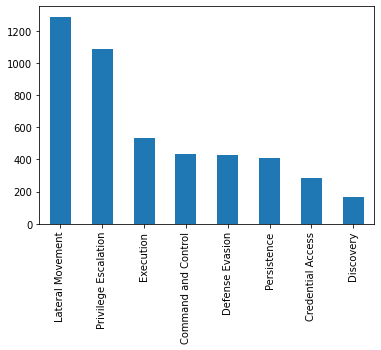

In [45]:
appended_data['EVTX_Tactic'].value_counts(sort=True).nlargest(8).plot.bar()

- ### Top 10 Tactics by EventIDs and Event Log Providers

<AxesSubplot:ylabel='EVTX_Tactic'>

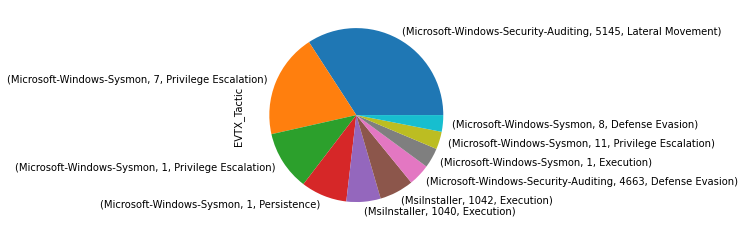

In [46]:
appended_data['EVTX_Tactic'].groupby([appended_data['ProviderName'], appended_data['EventID']]).value_counts(sort=True).nlargest(10).plot.pie()

- ### Top 30 RelativeTargetName of EventID 5145 by ShareName:
We noticed that the top EventID in Lateral Movement tactic was 5145 so next we will be checking top RelativeTargetName field values by ShareName since these are usually fields of interest when we try to hunt for Lateral Movement via remote SCM service or scheduled tasks creation for example.
This is only to provide examples of you can do interesting readings of the data provided in EVTX-ATTACK-SAMPLES project.


<AxesSubplot:ylabel='RelativeTargetName,ShareName'>

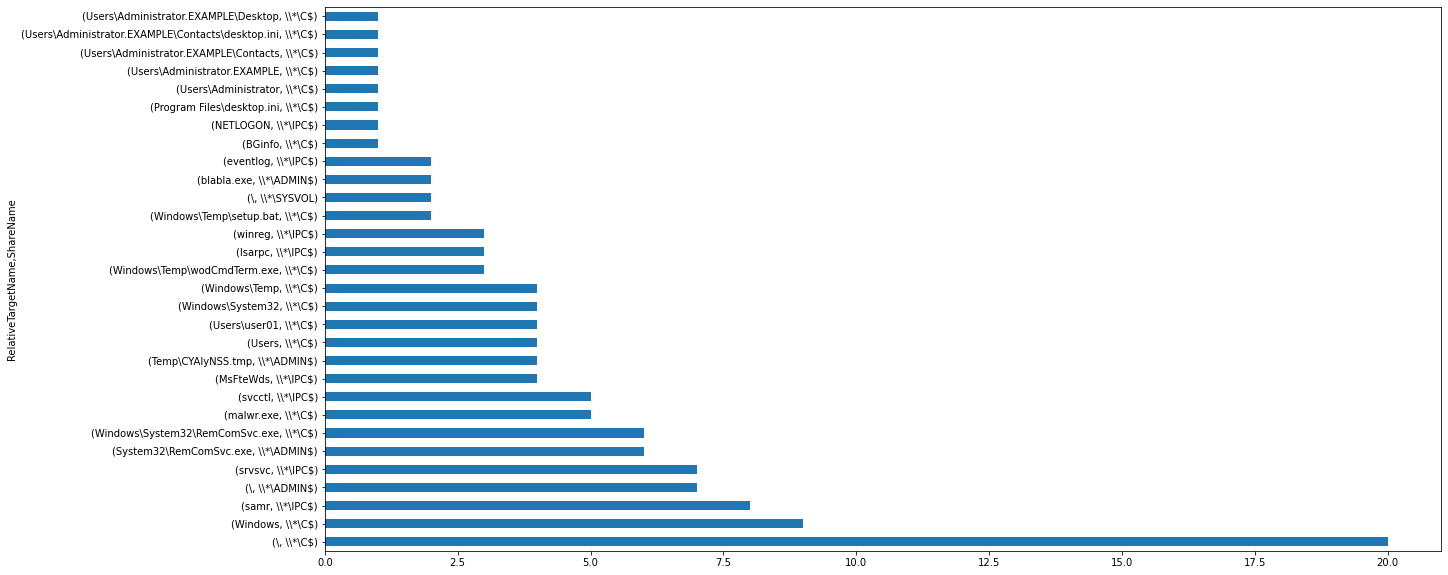

In [38]:
LM_5145 = appended_data.loc[appended_data['EventID'] == '5145']
LM_5145['ShareName'].groupby([LM_5145['RelativeTargetName']]).value_counts(sort=True).nlargest(30).plot.barh(figsize=(20,10))

## Saving parsed events in CSV file
Here we are saving parsed records without the raw field as a csv file so that we can access the data later without parsing events again.

In [41]:
appended_data_without_raw=appended_data.drop('raw', inplace=False, axis=1)
appended_data_without_raw.to_csv("evtx_data.csv")

## Reading saved data from CSV file

In [47]:
df = pd.read_csv("evtx_data.csv")

C:\Users\hamza\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,9,10,14,16,34,37,39,40,41,42,43,45,47,49,51,52,53,54,55,56,57,59,60,61,62,64,65,66,67,71,72,73,75,80,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,152,153,162,168,169,170,171,172,173,174,175,176,177,178,180,182,183,184,185,186,187,188,189,190,194,196,197,198,201,202,203,204,207,208,209,212,213,215,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,235,236,238,240,246,248,250,251,252,253,254,258,260,261,262,263,264,274,275,276,277,278,279,280,281,282,283,284,285,286,288,289,290,291,292,294,295,296,298,301,302,303,304,305,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,324,325) have mixed types.Specify dtype option on import or set low_memory=False.
  exe

In [49]:
df.head()

,Unnamed: 0,AuthenticationPackageName,Channel,Computer,EVTX_FileName,EVTX_Tactic,EventID,EventRecordID,Guid,IpAddress,IpPort,KeyLength,Keywords,Level,LmPackageName,LogonGuid,LogonProcessName,LogonType,ProviderName,Opcode,ProcessID,ProcessId,ProcessName,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,SystemTime,TargetDomainName,TargetLogonId,TargetUserName,TargetUserSid,Task,ThreadID,TransmittedServices,UserID,Version,WorkstationName,{Event_NS}EventXML,{Event_NS}Param1,{Event_NS}Param2,{Event_NS}Param3,{Event_NS}listenerName,Application,CommandLine,DestAddress,DestPort,Direction,FilterRTID,LayerName,LayerRTID,NewProcessId,NewProcessName,PrivilegeList,Protocol,RemoteMachineID,RemoteUserID,SourceAddress,SourcePort,TargetInfo,TargetLogonGuid,TargetServerName,TokenElevationType,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}LogFileCleared,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}SubjectDomainName,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}SubjectLogonId,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}SubjectUserName,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}SubjectUserSid,Company,CurrentDirectory,Description,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,FileVersion,Hashes,Image,ImageLoaded,Initiated,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,ProcessGuid,Product,RuleName,Signature,SignatureStatus,Signed,SourceHostname,SourceIp,SourceIsIpv6,SourcePortName,TerminalSessionId,User,UtcTime,Status,Workstation,AccessList,AccessMask,AccountExpires,AdditionalInfo,AdditionalInfo2,AllowedToDelegateTo,AppCorrelationID,AttributeLDAPDisplayName,AttributeSyntaxOID,AttributeValue,AuditPolicyChanges,CategoryId,ComputerAccountChange,DSName,DSType,DisplayName,DnsHostName,Dummy,HandleId,HomeDirectory,HomePath,LogonHours,NewUacValue,ObjectClass,ObjectDN,ObjectGUID,ObjectName,ObjectServer,ObjectType,OldUacValue,OpCorrelationID,OperationType,PasswordLastSet,PrimaryGroupId,ProfilePath,Properties,SamAccountName,ScriptPath,ServicePrincipalNames,SidHistory,SubcategoryGuid,SubcategoryId,TargetSid,TaskContentNew,TaskName,UserAccountControl,UserParameters,UserPrincipalName,UserWorkstations,CallTrace,Configuration,ConfigurationFileHash,CreationUtcTime,EventType,GrantedAccess,SchemaVersion,SourceImage,SourceProcessGUID,SourceProcessId,SourceThreadId,State,TargetFilename,TargetImage,TargetObject,TargetProcessGUID,TargetProcessId,ElevatedToken,FailureReason,ImpersonationLevel,RestrictedAdminMode,SubStatus,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,AccessReason,ResourceAttributes,RestrictedSidCount,TransactionId,NewThreadId,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetProcessGuid,RelativeTargetName,ShareLocalPath,ShareName,Binary,CertIssuerName,CertSerialNumber,CertThumbprint,PreAuthType,ServiceName,ServiceSid,TicketEncryptionType,TicketOptions,EVENT_PROCESSTERMINATION_CROSSPROCESS,EventSourceName,param1,param2,param3,param4,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,NewState,OriginalFileName,ResourceManager,PackageName,Details,PipeName,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}BackupPath,{http://manifests.microsoft.com/win/2004/08/windows/eventlog}Channel,AdvancedOptions,ConfigAccessPolicy,DisableIntegrityChecks,FlightSigning,HypervisorDebug,HypervisorLaunchType,HypervisorLoadOptions,KernelDebug,LoadOptions,RemoteEventLogging,TestSigning,VsmLaunchType,PreviousCreationUtcTime,CallerProcessId,CallerProcessName,{http://www.microsoft.com/Windows/Diagnosis/PCA/events}ExePath,{http://www.microsoft.com/Windows/Diagnosis/PCA/events}ResolverFiredEvent,{http://www.microsoft.com/Windows/Diagnosis/PCA/events}ResolverName,TaskContent,AdditionalInfoHr,Id,PeerContextInfo,bandwidthLimit,bytesTotal,bytesTransferred,bytesTransferredFromPeer,fileCount,fileLength,fileTime,hr,ignoreBandwidthLimitsOnLan,isRoami

## Generating Sankey Diagram
This part will be dedicated to putting together a Sankey Diagram that groups EventID, ProviderNAme and Tactic in one responsive visialisation. In the example bellow we will be focusing only on EventID 5145 you can do basically the same thing with any field you want.
> Reference : https://datavizardry.org/portfolio/sankey-diagram/

In [99]:
# Creatinf new DataFrame for Sankey Diagram with only needed columns
sankey_viz = appended_data[['EventID', 'ProviderName', 'EVTX_Tactic']]
# Creating a specific DataFrame to focus only EventID 5145
EID_5145 = sankey_viz.loc[sankey_viz['EventID'] == '5145']

In [88]:
EID_5145.head()

,EventID,ProviderName,EVTX_Tactic
543,5145,Microsoft-Windows-Security-Auditing,Credential Access
651,5145,Microsoft-Windows-Security-Auditing,Credential Access
653,5145,Microsoft-Windows-Security-Auditing,Credential Access
898,5145,Microsoft-Windows-Security-Auditing,Defense Evasion
902,5145,Microsoft-Windows-Security-Auditing,Defense Evasion


## Sankey Diagram DataFrames
Creating source – destination pairs to be joined later

In [91]:
df1=EID_5145.groupby(['EventID', 'ProviderName'], as_index=False)['EVTX_Tactic'].count()
df1.head(20)

,EventID,ProviderName,EVTX_Tactic
0,5145,Microsoft-Windows-Security-Auditing,950


In [92]:
df2=EID_5145.groupby(['EventID', 'EVTX_Tactic'], as_index=False)['ProviderName'].count()
df2.head(20)

,EventID,EVTX_Tactic,ProviderName
0,5145,Credential Access,3
1,5145,Defense Evasion,2
2,5145,Discovery,15
3,5145,Lateral Movement,929
4,5145,Privilege Escalation,1


In [93]:
df3=EID_5145.groupby(['ProviderName', 'EVTX_Tactic'], as_index=False)['EventID'].count()
df3.head(20)

,ProviderName,EVTX_Tactic,EventID
0,Microsoft-Windows-Security-Auditing,Credential Access,3
1,Microsoft-Windows-Security-Auditing,Defense Evasion,2
2,Microsoft-Windows-Security-Auditing,Discovery,15
3,Microsoft-Windows-Security-Auditing,Lateral Movement,929
4,Microsoft-Windows-Security-Auditing,Privilege Escalation,1


Each of the above data-frames have different column headers. Since we eventually want to append all of these in one data-frame, it would help us if we have common column header for each of these.

In [94]:
df1.columns = ['a', 'b', 'Count']
df2.columns = ['a', 'b', 'Count']
df3.columns = ['a', 'b', 'Count']
df4 = df1.append(df2)
df5 = df4.append(df3)
df5

,a,b,Count
0,5145,Microsoft-Windows-Security-Auditing,950
0,5145,Credential Access,3
1,5145,Defense Evasion,2
2,5145,Discovery,15
3,5145,Lateral Movement,929
4,5145,Privilege Escalation,1
0,Microsoft-Windows-Security-Auditing,Credential Access,3
1,Microsoft-Windows-Security-Auditing,Defense Evasion,2
2,Microsoft-Windows-Security-Auditing,Discovery,15
3,Microsoft-Windows-Security-Auditing,Lateral Movement,929


Defining the Sankey function

In [97]:
import plotly
#import chart_studio.plotly
import chart_studio.plotly as py

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#E35BBC','#4B8BBE','#D6D6D6','#306998']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [100]:
# Generate a SNAKEY Visualization
fig = genSankey(df5,cat_cols=['a','b'],value_cols='Count',title='EVTX Samples Sankey Diagram')
plotly.offline.plot(fig, validate=False)

'temp-plot.html'